In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import tensorflow.keras as keras 
import tensorflow as tf
import tensorflow_addons as tfa

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [5]:
df = pd.read_csv('../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv')

# Replace the ethinicty values ith real_categories
ethnicity_mapping = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Hispanic"}
df['ethnicity'].replace(ethnicity_mapping, inplace=True)

# One-hot encode the ethinicty values
tmp = pd.get_dummies(df['ethnicity'], prefix='eth')
df = pd.concat([df, tmp], axis=1)
df

,age,ethnicity,gender,img_name,pixels,eth_Asian,eth_Black,eth_Hispanic,eth_Indian,eth_White
0,1,Asian,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...,1,0,0,0,0
1,1,Asian,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...,1,0,0,0,0
2,1,Asian,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...,1,0,0,0,0
3,1,Asian,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...,1,0,0,0,0
4,1,Asian,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
23700,99,White,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...,0,0,0,0,1
23701,99,Black,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...,0,1,0,0,0
23702,99,Asian,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...,1,0,0,0,0
23703,99,Asian,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...,1,0,0,0,0


In [6]:
# Replace the gender values ith real_categories
gender_mapping = {0:"Male", 1:"Female"}
df['gender'].replace(gender_mapping, inplace=True)

# One-hot encode the ethinicty values
tmp = pd.get_dummies(df['gender'], prefix='gender')
df = pd.concat([df, tmp], axis=1)
df

,age,ethnicity,gender,img_name,pixels,eth_Asian,eth_Black,eth_Hispanic,eth_Indian,eth_White,gender_Female,gender_Male
0,1,Asian,Male,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...,1,0,0,0,0,0,1
1,1,Asian,Male,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...,1,0,0,0,0,0,1
2,1,Asian,Male,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...,1,0,0,0,0,0,1
3,1,Asian,Male,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...,1,0,0,0,0,0,1
4,1,Asian,Male,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
23700,99,White,Female,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...,0,0,0,0,1,1,0
23701,99,Black,Female,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...,0,1,0,0,0,1,0
23702,99,Asian,Female,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...,1,0,0,0,0,1,0
23703,99,Asian,Female,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...,1,0,0,0,0,1,0


Unique age values:  104


<AxesSubplot:xlabel='age', ylabel='Count'>

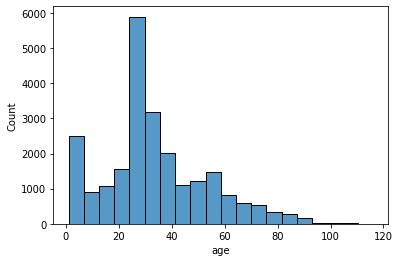

In [7]:
# Plotting the age values
print('Unique age values: ', df['age'].nunique())
sns.histplot(df['age'], bins=20)

In [8]:
# Coverting age to categorical values to solve it as a classififcation problem instead of regression problem
# If this is trained as a regression model, the age_values fluctuate too much during inference. 
def convert_age(age_value):
    
#     age_mapping = {0:'<10', 1:'11-15', 2:'16-20', 3:'21-25', 4:'26-30', 5:'31-35', 6:'36-42', 7:'43-50', 8:'51-60'. 9:'>60'}

    if age_value<=10:
        age_category = 0
    if 11<=age_value<=15:
        age_category = 1
    if 16<=age_value<=20:
        age_category = 2
    if 21<=age_value<=25:
        age_category = 3
    if 26<=age_value<=30:
        age_category = 4
    if 31<=age_value<=35:
        age_category = 5
    if 36<=age_value<=42:
        age_category = 6
    if 43<=age_value<=50:
        age_category = 7
    if 51<=age_value<=60:
        age_category = 8
    if age_value>60:
        age_category = 9
        
    return age_category

df['age_category'] = df['age'].apply(convert_age)
df

,age,ethnicity,gender,img_name,pixels,eth_Asian,eth_Black,eth_Hispanic,eth_Indian,eth_White,gender_Female,gender_Male,age_category
0,1,Asian,Male,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...,1,0,0,0,0,0,1,0
1,1,Asian,Male,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...,1,0,0,0,0,0,1,0
2,1,Asian,Male,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...,1,0,0,0,0,0,1,0
3,1,Asian,Male,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...,1,0,0,0,0,0,1,0
4,1,Asian,Male,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23700,99,White,Female,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...,0,0,0,0,1,1,0,9
23701,99,Black,Female,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...,0,1,0,0,0,1,0,9
23702,99,Asian,Female,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...,1,0,0,0,0,1,0,9
23703,99,Asian,Female,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...,1,0,0,0,0,1,0,9


In [9]:
# Dropping the images with ages less than 3 
to_drop = df[df['age']<=3].index
len(to_drop)
dfx = df.drop(to_drop, axis=0)
dfx['age_category'].value_counts()

# Randomly shuffle the dataset
dfx = dfx.sample(frac=1).reset_index(drop=True)

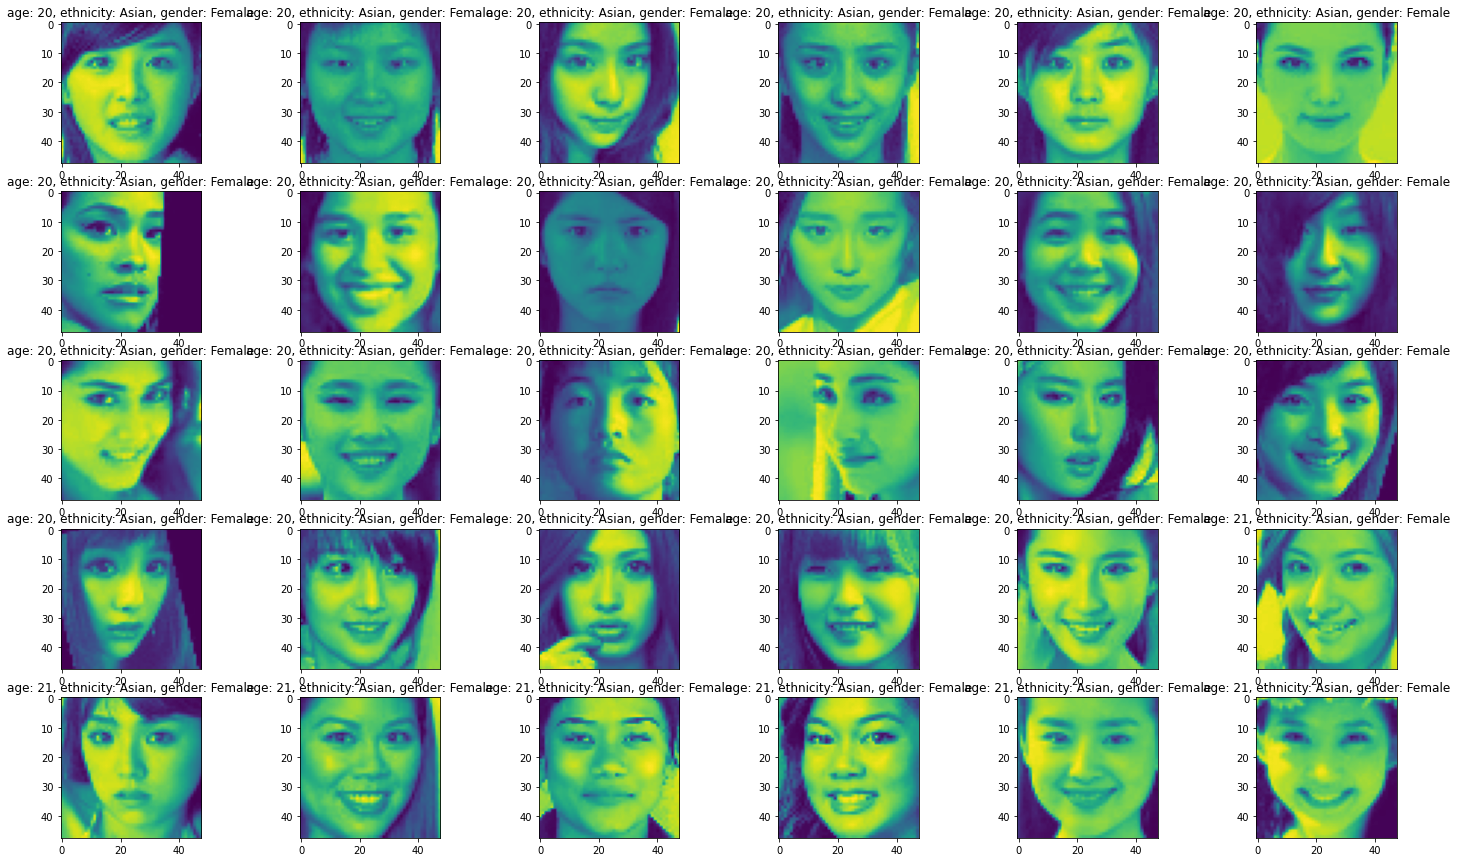

In [10]:
# Plotting some random images
eth = 'Asian'
age_min = 20
age_max = 50
gender = 'Female'

fig = plt.figure(figsize=(25,15))

tmp = df[(df['ethnicity']==eth) & (df['age']>=age_min) & (df['age']<=age_max)& (df['gender']==gender)].index[:30]

j=0
for i in tmp:
    j+=1
    ax = fig.add_subplot(5,6,j)
    ax.imshow(np.array(df['pixels'][i].split(' '), dtype='int64').reshape(48,48))
    plt.title(f'age: {df.age[i]}, ethnicity: {df.ethnicity[i]}, gender: {df.gender[i]}')

In [11]:
# Create inputs with targets from dataframe
def create_inputs_targets(df):
    images = np.zeros((len(df), 48, 48))

    for i in tqdm(range(len(df))):
        images[i] = (np.array(df['pixels'][i].split(' '), dtype='int64').reshape(48,48)/255.0)
     
    age_labels = np.array(df['age_category'])
    gender_labels = np.array(df[['gender_Female', 'gender_Male']])
    ethnicity_labels = np.array(df[['eth_Asian', 'eth_Black', 'eth_Hispanic', 'eth_Indian', 'eth_White']])
    
    return images, [age_labels, gender_labels, ethnicity_labels]

In [12]:
# Splitting the dataframe into 80-20% training and validation dataframes
validation_data_indices = dfx.sample(frac=0.2).index
validation_df = df.loc[validation_data_indices, :].reset_index(drop=True)

train_df = dfx.drop(validation_data_indices, axis=0).reset_index(drop=True)

x_train, y_train = create_inputs_targets(train_df)
x_val, y_val = create_inputs_targets(validation_df)

print('Training data shape:', x_train.shape, y_train[0].shape, y_train[1].shape, y_train[2].shape)
print('Validation data shape:', x_val.shape, y_val[0].shape, y_val[1].shape, y_val[2].shape)

100%|██████████| 4362/4362 [00:01<00:00, 3118.17it/s]

Training data shape: (17449, 48, 48) (17449,) (17449, 2) (17449, 5)
Validation data shape: (4362, 48, 48) (4362,) (4362, 2) (4362, 5)


In [13]:
# The model will be composed of three heads, one for each target: age, gender and race.
# I am using DenseNet169 as the base pretrained model here

class create_model():
    
    def __init__(self, im_width=48, im_height=48):
        
        self.im_height = im_height
        self.im_width = im_width
        
        # Initializing the base pretrained model
        self.base = keras.applications.DenseNet169(weights=None, include_top=False, input_shape=(self.im_height, self.im_width, 1))
        self.base.trainable=True
        self.base_output_layer = self.base.output

    # Making gender branch for gender prediction on top of the base model 
    def gender_branch(self):
        
        # Passing the output layer of the base preatined model to a flattening (global average pooling) layer
        x = keras.layers.GlobalAveragePooling2D()(self.base_output_layer)
        x = keras.layers.Dense(128, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(32, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(2, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros())(x)
        
        x = keras.layers.Activation('sigmoid', name='gender_output')(x)
        
        return x    
   
    # Making branch for age prediction on top of the base model 
    def age_branch(self): 
        
        # Passing the output layer of the base preatined model to a flattening (global average pooling) layer
        x = keras.layers.GlobalAveragePooling2D()(self.base_output_layer)
        x = keras.layers.Dense(128, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(32, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(10, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros())(x)
        
        x = keras.layers.Activation('softmax', name='age_output')(x)
        
        return x
    
    # Making branch for ethnicity prediction on top of the base model 
    def ethnicity_branch(self): 
        
        # Passing the output layer of the base preatined model to a flattening (global average pooling) layer
        x = keras.layers.GlobalAveragePooling2D()(self.base_output_layer)
        x = keras.layers.Dense(128, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(32, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros(), activation='relu')(x)
        x = keras.layers.Dense(5, 
            kernel_initializer=keras.initializers.RandomUniform(seed=50),
            bias_initializer=keras.initializers.Zeros())(x)
        
        x = keras.layers.Activation('softmax', name='ethnicity_output')(x)
        
        return x  
    
    def full_model(self):
       
        age_branch = self.age_branch()
        gender_branch = self.gender_branch()
        ethnicity_branch = self.ethnicity_branch() 
        
        model = keras.models.Model(inputs= self.base.input,
                     outputs = [age_branch, gender_branch, ethnicity_branch],
                     name="FACE_NET")        
        return model
    
m = create_model(im_width=48, im_height=48)
model = m.full_model()
model.summary()

2022-10-13 01:54:52.094825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 01:54:52.190119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 01:54:52.190880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 01:54:52.192017: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "FACE_NET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 24, 24, 64)   3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [14]:
losses = {'age_output': keras.losses.SparseCategoricalCrossentropy(), 
          'gender_output': keras.losses.BinaryCrossentropy(),
          'ethnicity_output': keras.losses.CategoricalCrossentropy()}

#Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs. 
#The loss value that will be minimized by the model will then be the weighted sum of all individual losses, weighted by the loss_weights coefficients. 
loss_weights = {'age_output': 1.0, 
                'gender_output': 0.5,
                'ethnicity_output':0.5}

metrices = {'age_output': [keras.metrics.SparseTopKCategoricalAccuracy(k=1)], 
            'gender_output': [keras.metrics.BinaryAccuracy()],
            'ethnicity_output': [keras.metrics.CategoricalAccuracy()]}

init_lr = 1e-4
epochs = 80

# Decay based on the learning rate divided by the number of epochs, to slowly decrease the learning rate over the epochs.
model.compile(optimizer = keras.optimizers.Adam(learning_rate=init_lr, decay=init_lr/epochs), 
              loss = losses,
              loss_weights = loss_weights,
              metrics=metrices)

my_callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)]

hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=32, callbacks=my_callbacks)

2022-10-13 01:55:02.879757: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80


2022-10-13 01:55:18.904344: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


546/546 [==============================] - 74s 95ms/step - loss: 2.9306 - age_output_loss: 2.0392 - gender_output_loss: 0.5254 - ethnicity_output_loss: 1.2574 - age_output_sparse_top_k_categorical_accuracy: 0.2620 - gender_output_binary_accuracy: 0.7333 - ethnicity_output_categorical_accuracy: 0.5150 - val_loss: 3.1129 - val_age_output_loss: 2.1273 - val_gender_output_loss: 0.6082 - val_ethnicity_output_loss: 1.3630 - val_age_output_sparse_top_k_categorical_accuracy: 0.2288 - val_gender_output_binary_accuracy: 0.6619 - val_ethnicity_output_categorical_accuracy: 0.4374
Epoch 2/80
546/546 [==============================] - 49s 89ms/step - loss: 2.4542 - age_output_loss: 1.7661 - gender_output_loss: 0.3575 - ethnicity_output_loss: 1.0188 - age_output_sparse_top_k_categorical_accuracy: 0.3433 - gender_output_binary_accuracy: 0.8407 - ethnicity_output_categorical_accuracy: 0.6192 - val_loss: 2.4788 - val_age_output_loss: 1.7367 - val_gender_output_loss: 0.3727 - val_ethnicity_output_loss: 1

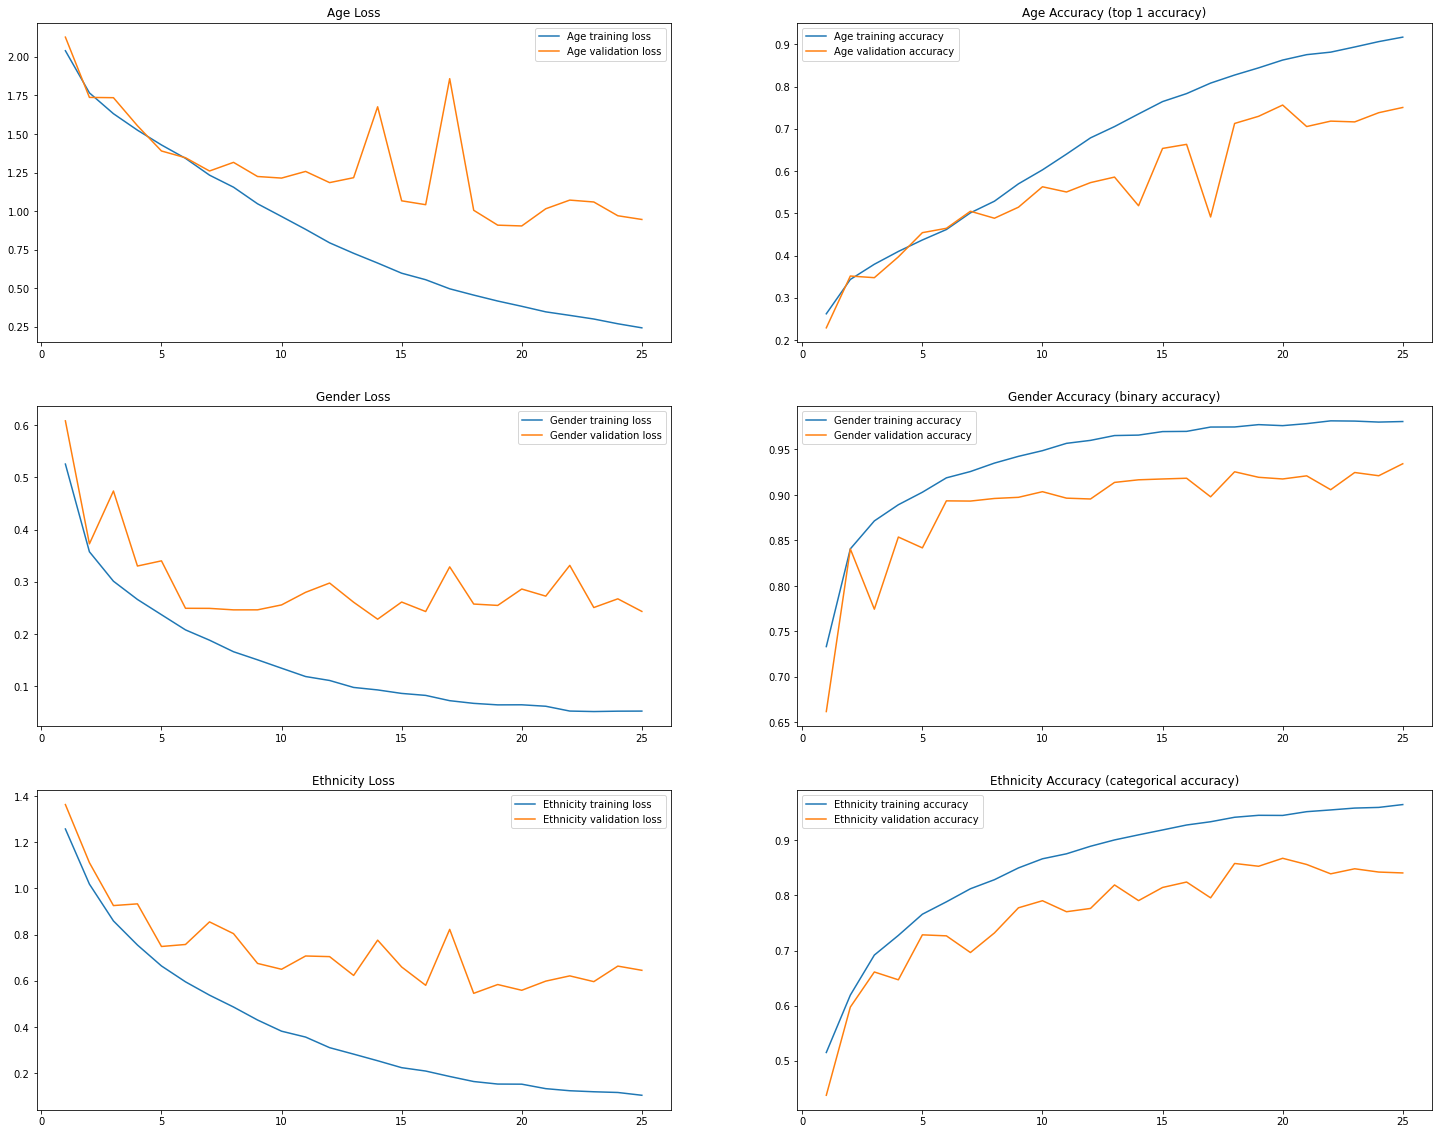

In [16]:
# plotting loss graph
fig = plt.figure(figsize=(25,20))
width = 2
height = 3

epochs = [i+1 for i in range(len(hist.history['loss']))]

# Age losses
ax = fig.add_subplot(height,width,1)
sns.lineplot(x = epochs, y = hist.history['age_output_loss'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_age_output_loss'], ax=ax)
plt.title('Age Loss')
plt.legend(['Age training loss', 'Age validation loss'])

# Age accuracy
ax = fig.add_subplot(height,width,2)
sns.lineplot(x = epochs, y = hist.history['age_output_sparse_top_k_categorical_accuracy'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_age_output_sparse_top_k_categorical_accuracy'], ax=ax)
plt.title('Age Accuracy (top 1 accuracy)')
plt.legend(['Age training accuracy', 'Age validation accuracy'])

# Gender losses
ax = fig.add_subplot(height,width,3)
sns.lineplot(x = epochs, y = hist.history['gender_output_loss'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_gender_output_loss'], ax=ax)
plt.title('Gender Loss')
plt.legend(['Gender training loss', 'Gender validation loss'])

# Gender accuracy
ax = fig.add_subplot(height,width,4)
sns.lineplot(x = epochs, y = hist.history['gender_output_binary_accuracy'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_gender_output_binary_accuracy'], ax=ax)
plt.title('Gender Accuracy (binary accuracy)')
plt.legend(['Gender training accuracy', 'Gender validation accuracy'])

ax = fig.add_subplot(height,width,5)
sns.lineplot(x = epochs, y = hist.history['ethnicity_output_loss'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_ethnicity_output_loss'], ax=ax)
plt.title('Ethnicity Loss')
plt.legend(['Ethnicity training loss', 'Ethnicity validation loss'])

ax = fig.add_subplot(height,width,6)
sns.lineplot(x = epochs, y = hist.history['ethnicity_output_categorical_accuracy'], ax=ax)
sns.lineplot(x = epochs, y = hist.history['val_ethnicity_output_categorical_accuracy'], ax=ax)
plt.title('Ethnicity Accuracy (categorical accuracy)')
plt.legend(['Ethnicity training accuracy', 'Ethnicity validation accuracy'])

In [17]:
predictions = model.predict(x_val)

In [18]:
age_true = validation_df['age_category']
age_true = np.array(age_true)

age_pred = [np.argmax(predictions[0][i]) for i in range(len(x_val))]

age_map = {0:'<10', 1:'11-15', 2:'16-20', 3:'21-25', 4:'26-30', 5:'31-35', 6:'36-42', 7:'43-50', 8:'51-60', 9:'>60'}
reverse_age_map = {y:x for x,y in age_map.items()}

age_report = classification_report(age_true, age_pred, target_names=reverse_age_map.keys())
print(age_report)

              precision    recall  f1-score   support

         <10       0.97      0.88      0.92       540
       11-15       0.59      0.85      0.70       134
       16-20       0.77      0.70      0.74       225
       21-25       0.80      0.75      0.77       562
       26-30       0.82      0.82      0.82       996
       31-35       0.78      0.61      0.68       498
       36-42       0.69      0.60      0.64       469
       43-50       0.54      0.65      0.59       295
       51-60       0.66      0.84      0.74       438
         >60       0.74      0.83      0.78       205

    accuracy                           0.76      4362
   macro avg       0.73      0.75      0.74      4362
weighted avg       0.77      0.76      0.76      4362



In [33]:
gender_true = validation_df['gender'].apply(lambda x: 1 if x == 'Female' else 0)
gender_true = np.array(gender_true)

gender_pred = [round(predictions[1][i][0]) for i in range(len(x_val))]
gender_map = {0:'Male', 1:'Female'}

gender_report = classification_report(gender_true, gender_pred, target_names={'male':0, 'female':1}.keys())
print(gender_report)

              precision    recall  f1-score   support

        male       0.89      0.96      0.92      2232
      female       0.95      0.87      0.91      2130

    accuracy                           0.92      4362
   macro avg       0.92      0.92      0.92      4362
weighted avg       0.92      0.92      0.92      4362



In [34]:
eth_true = validation_df[['eth_Asian','eth_Black','eth_Hispanic','eth_Indian','eth_White']].values
eth_true = [np.argmax(eth_true[i]) for i in range(len(eth_true))]

eth_pred = [np.argmax(predictions[2][i]) for i in range(len(x_val))]

# This eth map is not the same as the ethnicity_mapping dict. 
# When ethinicity data was one hot encoded pandas encoded it in alphabetical order

eth_map = {0: 'Asian', 1: 'Black', 2: 'Hispanic', 3: 'Indian', 4: 'White'}
reverse_eth_map = {y:x for x,y in eth_map.items()}

eth_report = classification_report(eth_true, eth_pred, target_names=reverse_eth_map.keys())
print(eth_report)

              precision    recall  f1-score   support

       Asian       0.90      0.83      0.86       617
       Black       0.90      0.92      0.91       872
    Hispanic       0.72      0.62      0.67       353
      Indian       0.95      0.74      0.83       762
       White       0.84      0.96      0.90      1758

    accuracy                           0.87      4362
   macro avg       0.86      0.81      0.83      4362
weighted avg       0.87      0.87      0.86      4362



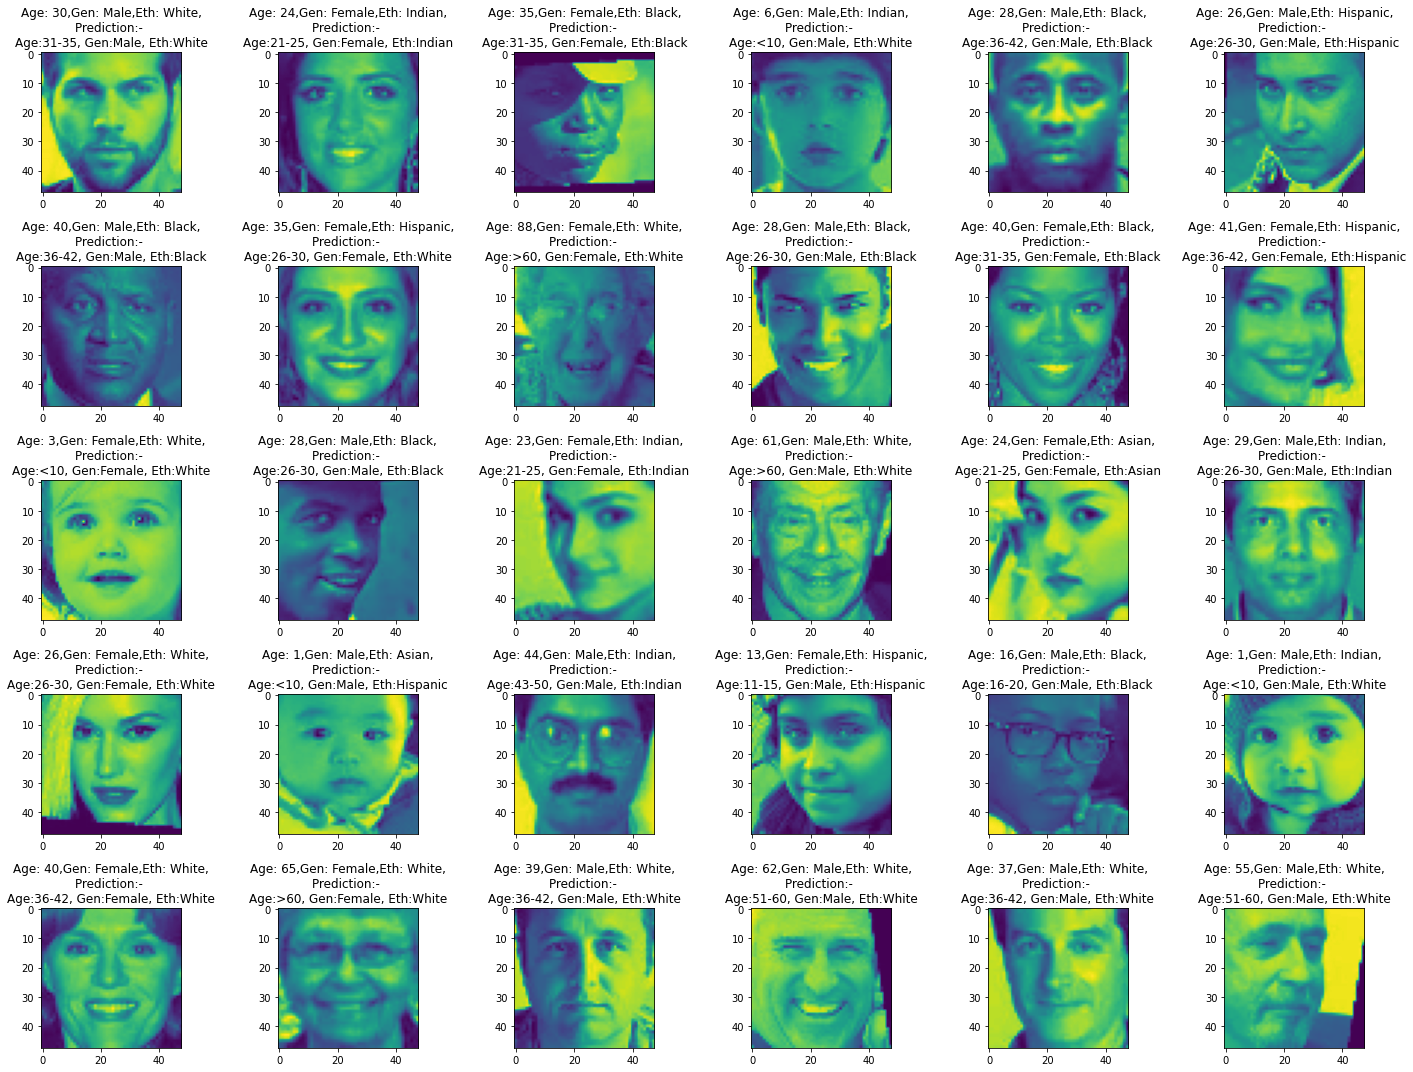

In [40]:
# Plotting some random images
random_indices = [np.random.randint(low=0, high=len(df)) for i in range(30)]

fig = plt.figure(figsize=(20,15))

for i in range(len(random_indices)):
    ax = fig.add_subplot(5,6,i+1)
    index = random_indices[i]
    img = df['pixels'][index]
    img = np.array(img.split(' '), dtype='int64').reshape(48,48)/255.0
    ax.imshow(img)
    
    output = model.predict(np.reshape(img, (1,48,48)))
    
    age, gender, eth = np.argmax(output[0]), round(output[1][0][0]), np.argmax(output[2])
    age = age_map[age]
    gender = gender_map[gender]
    ethnicity = eth_map[eth]
    
    plt.title(f'Age: {df.age[index]},Gen: {df.gender[index]},Eth: {df.ethnicity[index]},\nPrediction:- \nAge:{age}, Gen:{gender}, Eth:{ethnicity}')
    
fig.tight_layout()
plt.savefig('./facenet_predict.jpg')

In [29]:
# model.save('./face_net_age_gender_ethnicity.h5')